# Peer-graded Assignment: DTSA 5511 Introduction to Deep Learning Final Project

## Author: Anh Nguyen Sy Tung

## Credit Card Fraud Detection with Neural Networks

#### About:

The project involves using an autoencoder neural network to analyze a credit card transaction dataset and identify fraudulent transactions. The dataset, sourced from Kaggle, consists of 284,807 records, with only 492 marked as fraudulent and the rest marked as valid.

Autoencoders are a specific type of neural network that comprises an encoder and a decoder section. The encoder reduces the dimensions or features of the input data, while the decoder reconstructs it back to its original size. This process allows the autoencoder to learn how to represent the data with fewer dimensions. Unlike Principal Component Analysis (PCA), which relies on linear relationships between dimensions and target outputs, autoencoders can handle more complex relationships.

In this project, the dataset contains 28 columns named V1 - V28, with no clear explanation of their meanings. By using an autoencoder, it is possible to achieve accurate results without the need to determine if linear relationships exist within the dataset.

This notebook can be downloaded from https://github.com/tanh3ka/Master-of-Science-in-Data-Science-5511.


In [1]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Activation, Dense, Dropout
from keras.layers import Flatten, MaxPooling2D, Rescaling
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
#import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:
print("Keras version:",keras.__version__)
print("TensorFlow version:",tf.__version__)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    #print("\n", gpu_info)
    print("Connected to a GPU")

Keras version: 2.10.0
TensorFlow version: 2.10.0
Connected to a GPU


In [3]:
#Gloabals
DATA_DIR = "./data"
LABELS = ["Valid", "Fraud"]
ENCODER_ACTIVATION = "selu"
RANDOM_SEED = 42
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

#### Data:
The dataset consists of credit card transactions made by European cardholders in September 2013. The dataset covers a period of two days and includes a total of 284,807 transactions. Out of these transactions, only 492 are identified as fraudulent.

The dataset primarily consists of numerical input variables, which have been generated through a PCA transformation. Unfortunately, due to confidentiality concerns, the original features and additional background information about the data are not available. The dataset includes 28 principal components (V1, V2, ..., V28), which have undergone PCA transformation. However, the features 'Time' and 'Amount' have not been transformed. 'Time' represents the time elapsed in seconds between each transaction and the first transaction recorded in the dataset, while 'Amount' represents the transaction amount.

The 'Class' feature serves as the response variable, indicating whether a transaction is fraudulent (with a value of 1) or not (with a value of 0).


Link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


In [30]:
df_cc_all = pd.read_csv(os.path.join(DATA_DIR, "creditcard.csv"))

#### EDA:

In [31]:
print("Records in dataset: {0}\n".format(len(df_cc_all)))
print(df_cc_all.describe())
df_cc_all.head(2)

Records in dataset: 284807

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.918649e-15  5.682686e-16 -8.761736e-15  2.811118e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552103e-15  2.040130e-15 -1.698953e-15 -1.893285e-16 -3.147640e-15   
std    1.38024

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


We will now create a pie chart to validate the classification counts mentioned in the data description on Kaggle. The chart confirms that out of the total 284,807 records, there are 492 transactions labeled as fraudulent, while the remaining 284,315 are classified as valid. This indicates that approximately 0.17% of the transactions are identified as fraudulent.

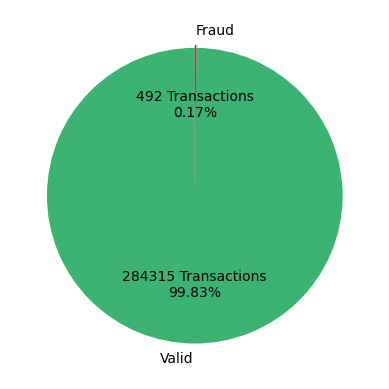

In [32]:
def makePiePlot(df):
    values = [len(df[df.Class == 0]), len(df[df.Class == 1])]
    plt.pie(values, explode = [.01, .01], labels = LABELS, colors = ['mediumseagreen', 'crimson'], 
            autopct = (lambda value:f'{value * sum(values) / 100 :.0f} Transactions\n{value:.2f}%'), 
            pctdistance = 0.6, shadow = False, labeldistance = 1.1, startangle = 90, 
            radius = 1, counterclock = True, wedgeprops = None, textprops = None, center = (0, 0), 
            frame = False, rotatelabels = False, normalize = True, data = None)
    plt.show()

makePiePlot(df_cc_all)


Since there is no available information about the features V1 - V28, the following code cell goes through each feature, excluding "Class," and shows the density histogram for both valid and fraudulent transactions. This step can be helpful during the modeling phase of the assignment as it allows us to understand the distribution of the data for each feature and potentially optimize the data presentation to the autoencoder, resulting in improved performance.

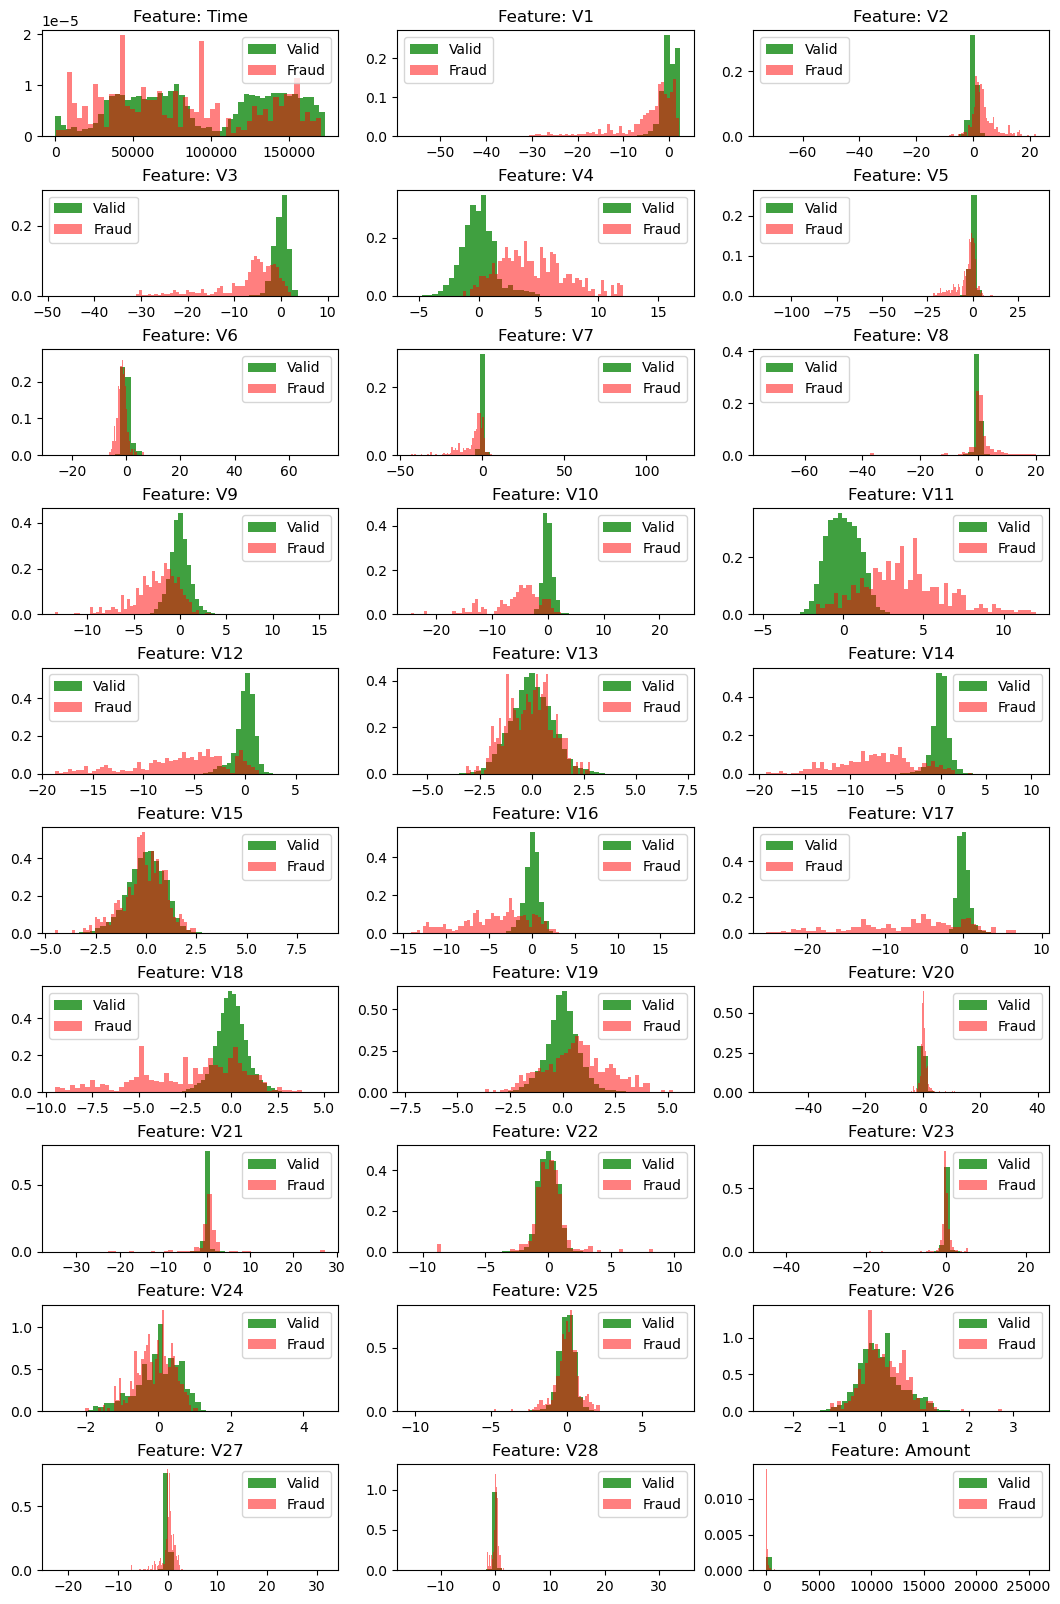

In [33]:
features = df_cc_all.columns[:-1].values

cols = 3
rows = len(features) // cols
fig, ax = plt.subplots(rows, cols, figsize=(13, 20))

for i, feature in enumerate(df_cc_all[features]):
    ax[i // cols, i % cols].hist(df_cc_all[feature][df_cc_all.Class == 0], bins=50, 
            density = True, alpha = 0.75, color = 'green', label = 'Valid')
    ax[i // cols, i % cols].hist(df_cc_all[feature][df_cc_all.Class == 1], bins=50, 
         density = True, alpha = 0.5, color = 'red', label = 'Fraud')
    ax[i // cols, i % cols].set_title('Feature: ' + str(feature))
    ax[i // cols, i % cols].legend()

plt.subplots_adjust(hspace = 0.5)
plt.show()

#### Data Wrangling:

In [34]:
df_cc_all = df_cc_all.drop('Time', axis=1)

features = df_cc_all.columns[:-1].values
numFeatures = len(features)

for feature in features:
    mean, std = df_cc_all[feature].mean(), df_cc_all[feature].std()
    df_cc_all.loc[:, feature] = (df_cc_all.loc[:, feature] - mean) / std


The next step involves calculating the count of the smaller class (fraudulent transactions) and then taking a random sample from the larger class to create a balanced dataset. This ensures that both classes have an equal number of samples. Prior to using this newly created dataset, another pie chart is generated to confirm that the classes are now balanced.

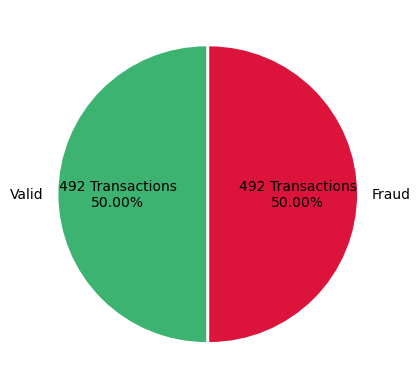

In [35]:
def getSubset(df, count, rank):
    return df[df.Class == rank].sample(n = count, replace = False, random_state = RANDOM_SEED)

lowCount = min(len(df_cc_all[df_cc_all.Class == 0]), len(df_cc_all[df_cc_all.Class == 1]))

dfValid = getSubset(df_cc_all, lowCount, 0)
dfFraud = getSubset(df_cc_all, lowCount, 1)

df_balanced = pd.concat([dfValid, dfFraud])#.sample(frac = 1, random_state = RANDOM_SEED)

makePiePlot(df_balanced)
  

In the following code cell, a correlation matrix is generated, revealing a significant number of correlated features. Notably, features V1 - V18 (excluding V6, V13, and V15) exhibit darker colors, indicating stronger correlations. While no immediate action will be taken based on this information, it could prove useful during the modeling phase of the assignment. Adjusting the data presented to the autoencoder based on these correlations may enhance its performance.

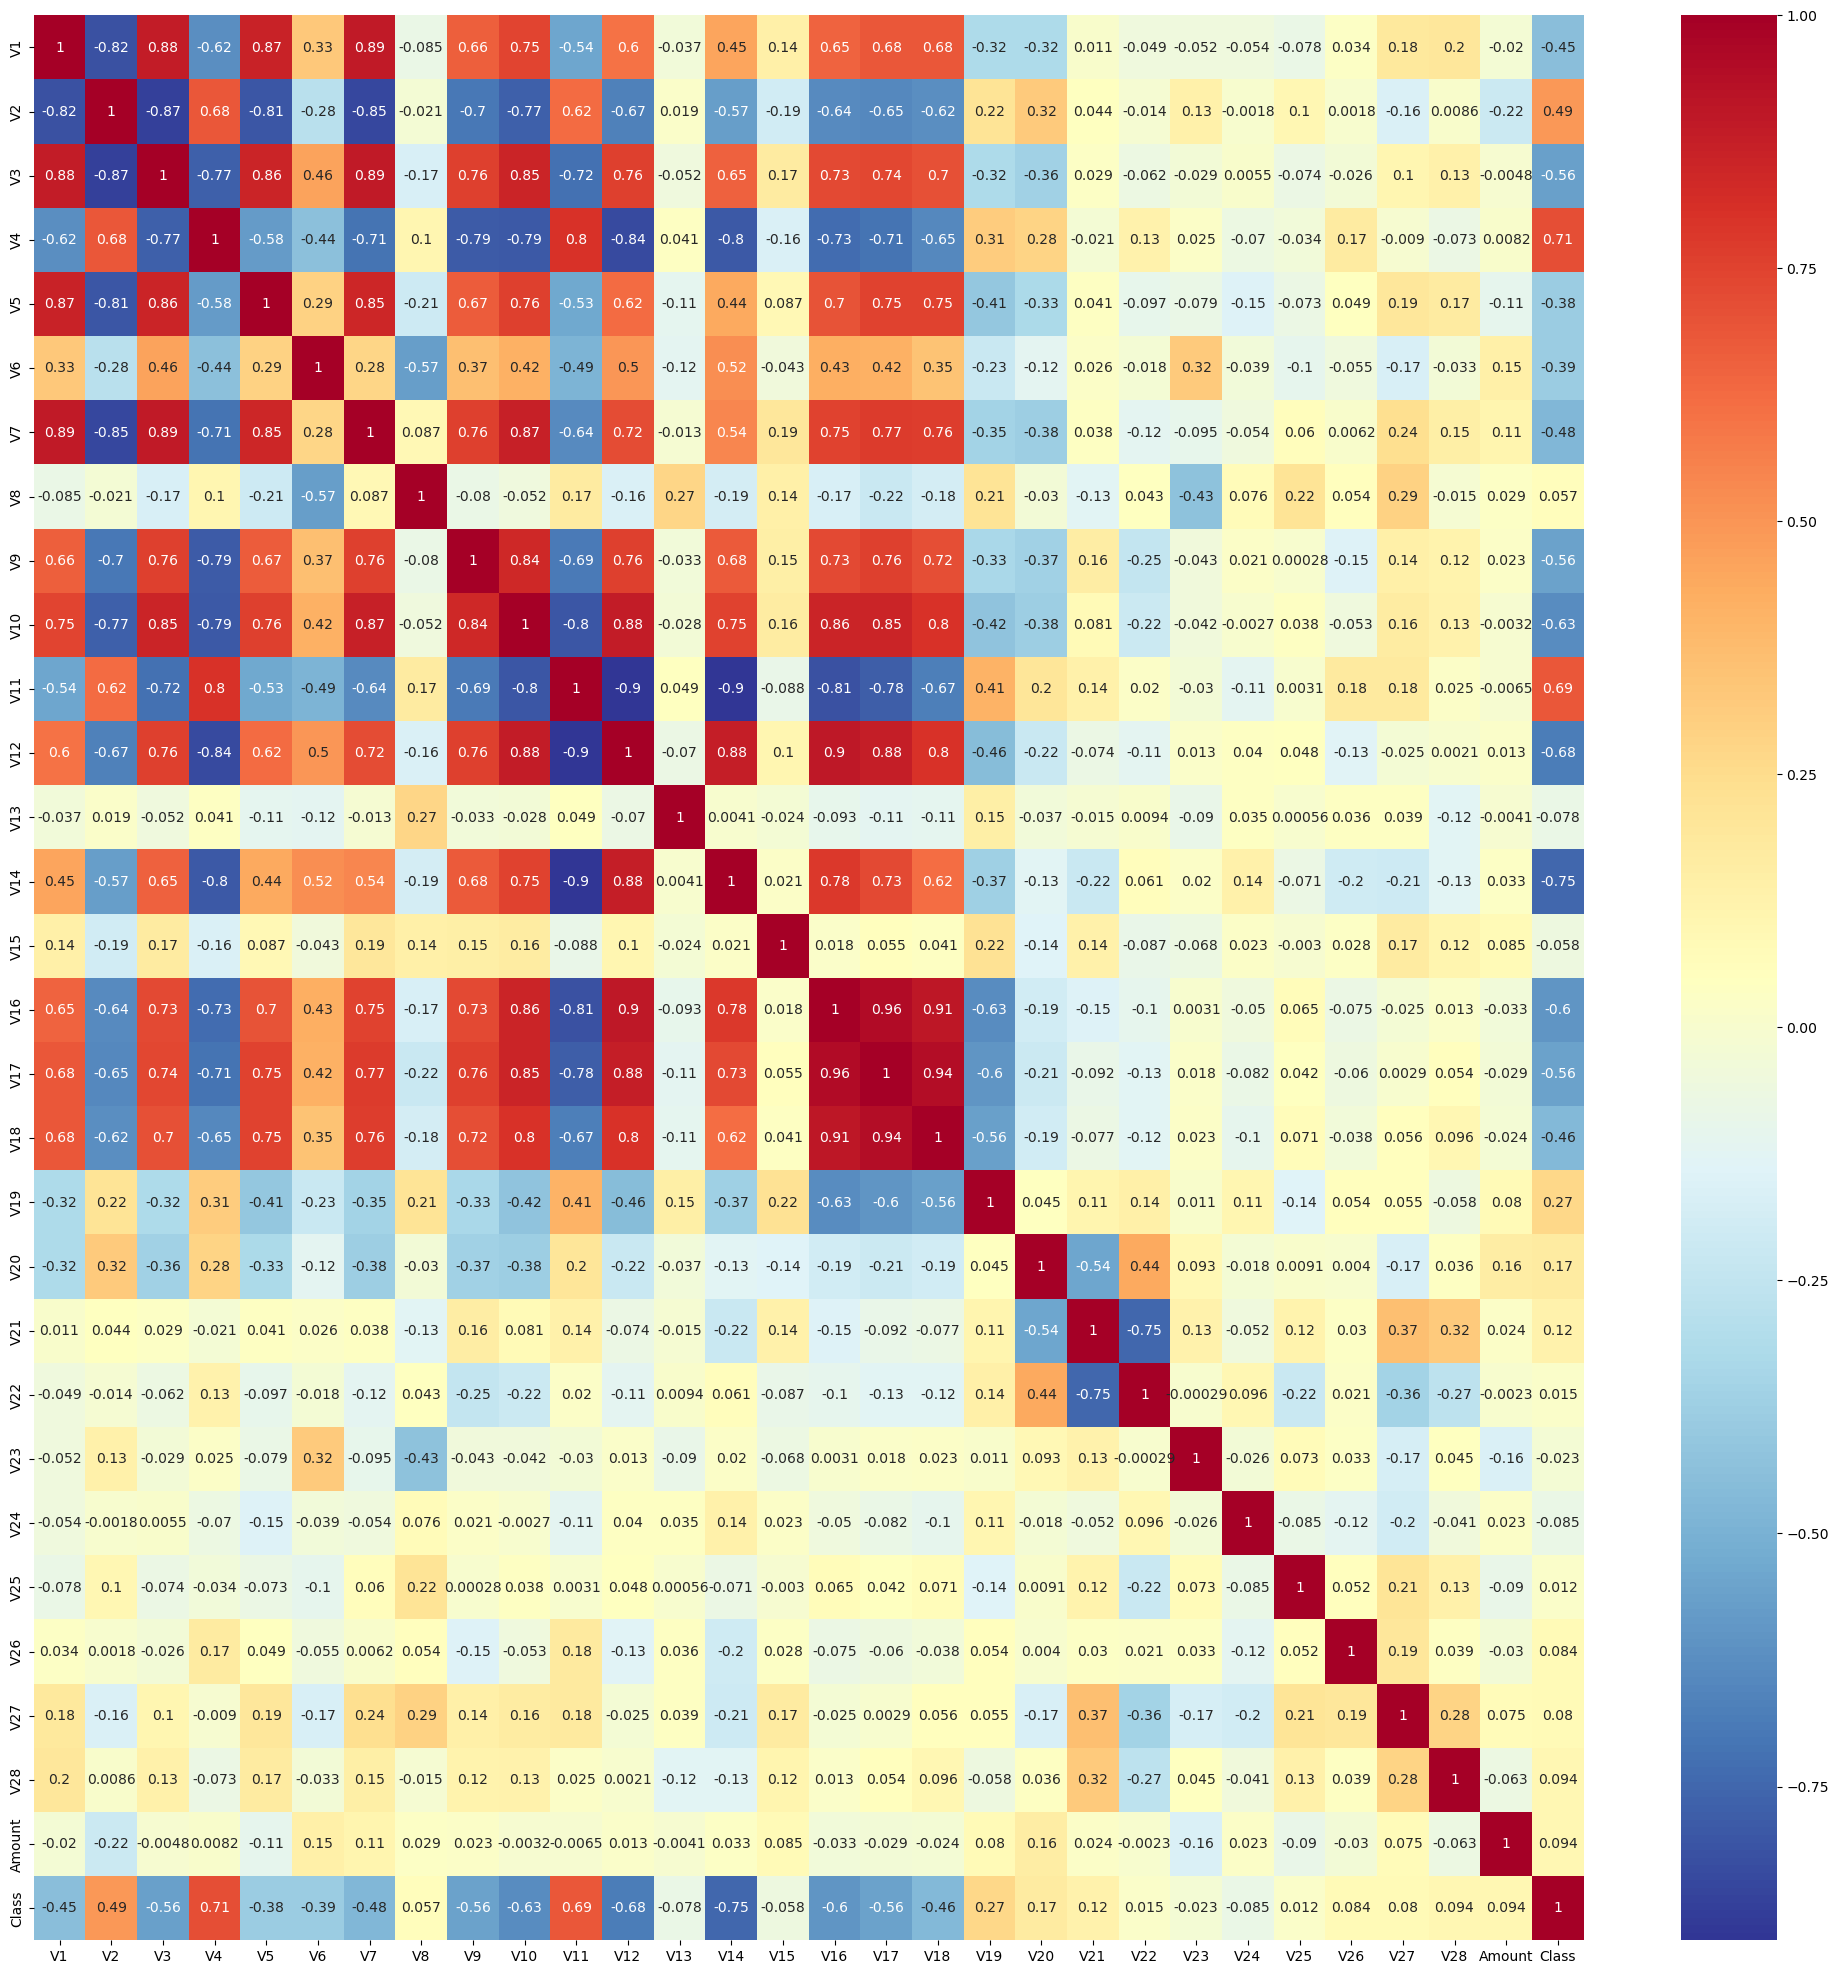

In [36]:
plt.figure(figsize = (25, 25))
sns.heatmap(df_balanced.corr(), annot = True, cmap = "RdYlBu_r")
plt.show()

#### Model:

In [77]:
def plotResults(origin, history, actuals, predictions):
    dataName = "Validation Data"
    fig, ax = plt.subplots(2, 2, figsize=(13, 10))

    print("On the " + dataName)

    print("AUC: {0}".format(roc_auc_score(actuals, predictions)))

    binaryPredictions = np.where(predictions < .5, 0, 1)
    print("F1 Score: ", f1_score(actuals, binaryPredictions))
      
    upper = len(history['loss']) + 1

    ax[0, 0].plot(np.arange(origin + 1, upper), history['loss'][origin:], label = 'Training')
    ax[0, 0].plot(np.arange(origin + 1, upper), history['val_loss'][origin:], label = 'Validation', color = 'red')
    ax[0, 0].set(xticks=np.arange(origin, upper, upper // 10))
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].set_title("Loss w/" + dataName)
    ax[0, 0].legend()

    ax[0, 1].plot(np.arange(origin + 1, upper), history['accuracy'][origin:], label = 'Training')
    ax[0, 1].plot(np.arange(origin + 1, upper), history['val_accuracy'][origin:], label = 'Validation', color = 'red')
    ax[0, 1].set(xticks=np.arange(origin, upper, upper // 10))
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_title("Accuracy w/" + dataName)
    ax[0, 1].legend()

    fpr, tpr, threshold = roc_curve(actuals, predictions)
    ax[1, 0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % history['val_auc'][-1])
    ax[1, 0].set_xlabel('False Positive Rate')
    ax[1, 0].set_ylabel('True Positive Rate')
    ax[1, 0].set_title(dataName + " ROC")
    ax[1, 0].legend(loc="lower right")

    cm = confusion_matrix(actuals, binaryPredictions)

    ax[1, 1].matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[1, 1].text(x = j, y = i, s = cm[i, j], va='center', ha='center', size='xx-large')
    ax[1, 1].set_xlabel("Confusion Matrix on\n" + dataName + "\n(0 = Negative, 1 = Positive)", fontsize = 14)
    ax[1, 1].set_ylabel('Actuals', fontsize = 12)
    ax[1, 1].set_title('Predictions', fontsize = 12)

    plt.subplots_adjust(hspace = 0.4)
    plt.show()

Split the balanced dataset with 20% for validation:

In [93]:
y = df_balanced.Class.values
X = df_balanced.drop('Class', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = RANDOM_SEED)


In [39]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, 
    verbose = False, mode = 'min', min_lr = 1e-20
)
earlyStop = EarlyStopping(monitor='loss', patience = 5)

callbacks_list = [reduce_lr, earlyStop]


7/7 [==============================] - 0s 1ms/step
On the Validation Data
AUC: 0.9815502166748047
F1 Score:  0.9270833333333334


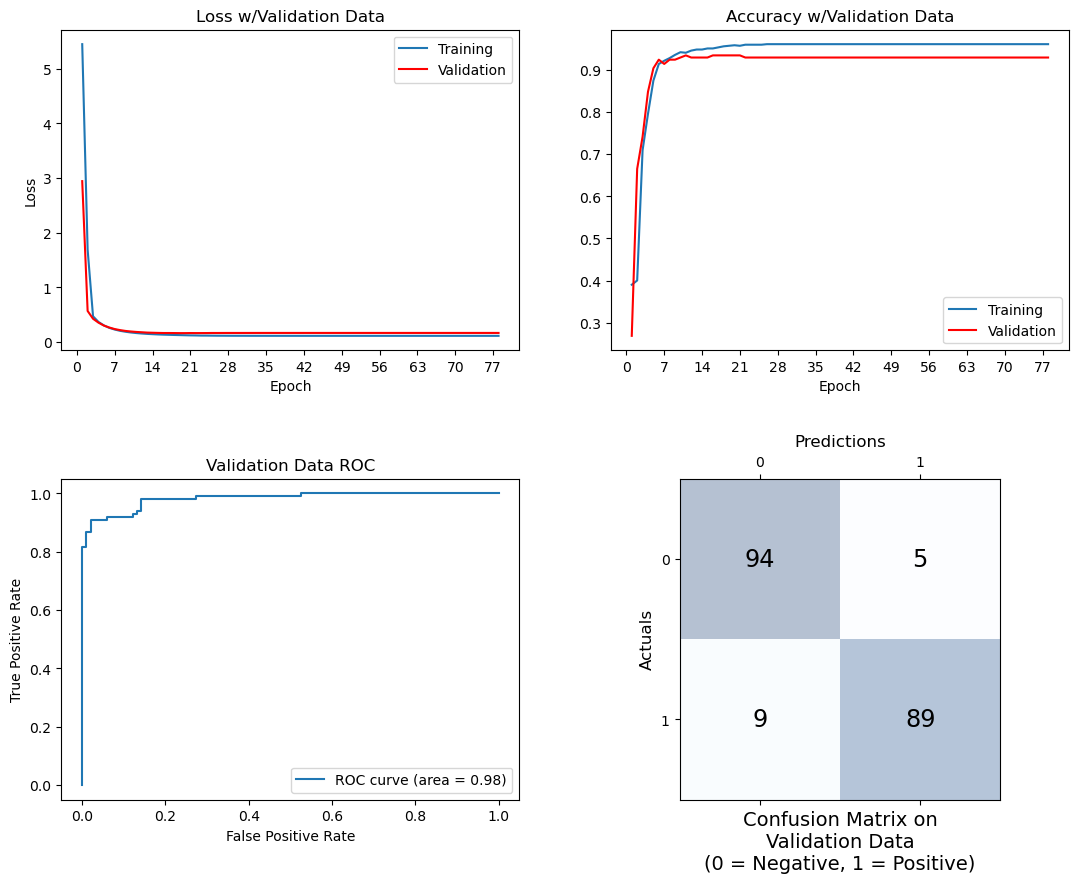

In [17]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(numFeatures, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model = keras.models.Sequential([stackedEncoder, stackedDecoder])
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, numFeatures)
model.build(input_shape)

histModel_1 = model.fit(X_train, y_train, epochs = 100, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_1.history, y_test, model.predict(X_test))

Despite using a basic autoencoder, the results obtained so far are remarkable, with an AUC (Area Under the Curve) of around 0.9816 and an F1 score of approximately 0.9271.

Further enhancements were made by introducing an additional dense layer with 4 units in the encoder and 16 units in the decoder, creating a mirrored structure. This improvement led to an increased AUC of approximately 0.9837. However, there was a slight decrease in the F1 score, which now stands at approximately 0.9223.

7/7 [==============================] - 0s 1ms/step
On the Validation Data
AUC: 0.9837148785591125
F1 Score:  0.922279792746114


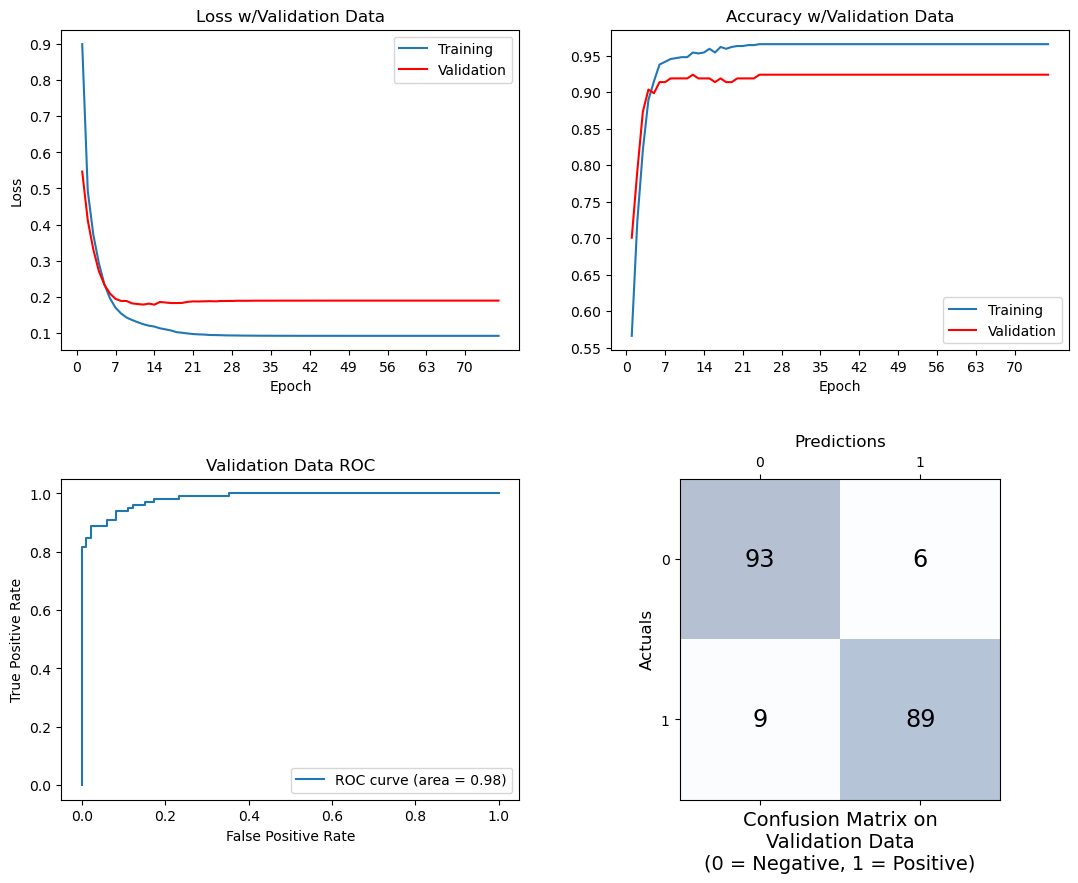

In [16]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(4, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(numFeatures, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model = keras.models.Sequential([stackedEncoder, stackedDecoder])
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, numFeatures)
model.build(input_shape)

histModel_2 = model.fit(X_train, y_train, epochs = 100, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_2.history, y_test, model.predict(X_test))

The next step involves experimenting with a 3-layer autoencoder, which leads to further improvements in performance. The AUC increases to approximately 0.9863, indicating better overall classification accuracy, and the F1 score improves to approximately 0.9326, demonstrating enhanced precision and recall.

7/7 [==============================] - 0s 1ms/step
On the Validation Data
AUC: 0.9863430857658386
F1 Score:  0.9326424870466321


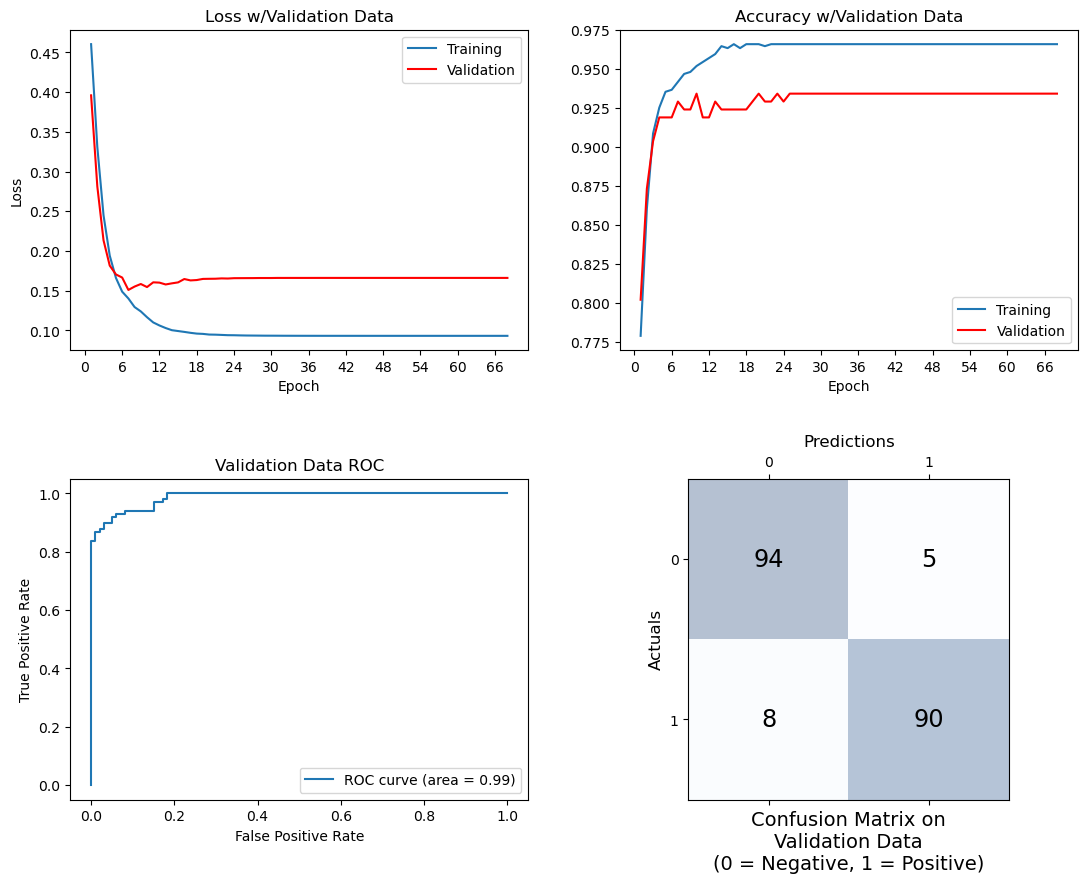

In [15]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(4, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(numFeatures, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model = keras.models.Sequential([stackedEncoder, stackedDecoder])
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, numFeatures)
model.build(input_shape)

histModel_3 = model.fit(X_train, y_train, epochs = 100, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_3.history, y_test, model.predict(X_test))

The results obtained from the 3-layer model are highly promising, and this architecture will be utilized to tune the hyperparameters. The model will be saved in the next code cell for potential use with the full dataset in the future.

In [ ]:
model.save(os.path.join("./Models/", "final_model.h5"))

#### Hyperparameter Tuning:

7/7 [==============================] - 0s 1ms/step
On the Validation Data
AUC: 0.9810348381776953
F1 Score:  0.9333333333333333


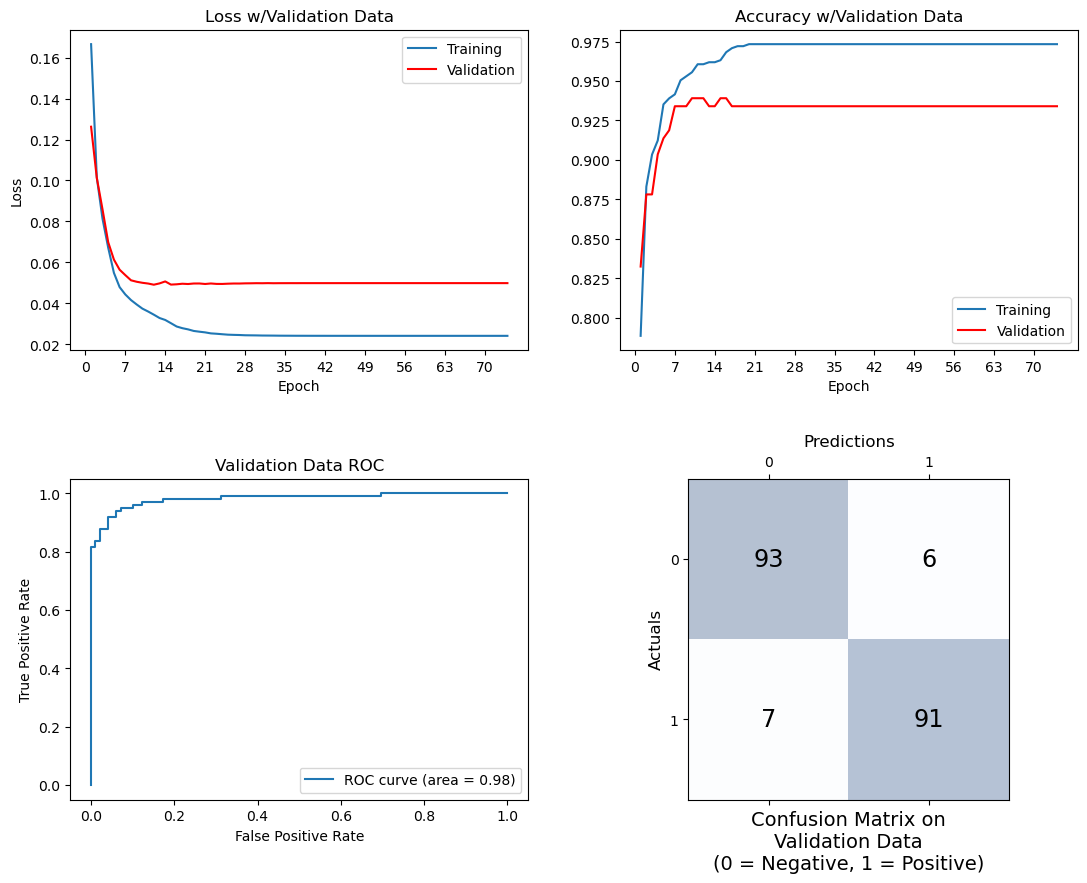

In [78]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(4, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(numFeatures, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model = keras.models.Sequential([stackedEncoder, stackedDecoder])
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = "mse", 
      metrics = METRICS
)

input_shape = (None, numFeatures)
model.build(input_shape)

histModel_4 = model.fit(X_train, y_train, epochs = 100, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_4.history, y_test, model.predict(X_test))

=> Even after switching to a rectified linear unit (ReLU) activation function, there was no noticeable improvement in the results obtained. The performance of the model remained similar to the previous configurations.

7/7 [==============================] - 0s 2ms/step
On the Validation Data
AUC: 0.9774273345701916
F1 Score:  0.9333333333333333


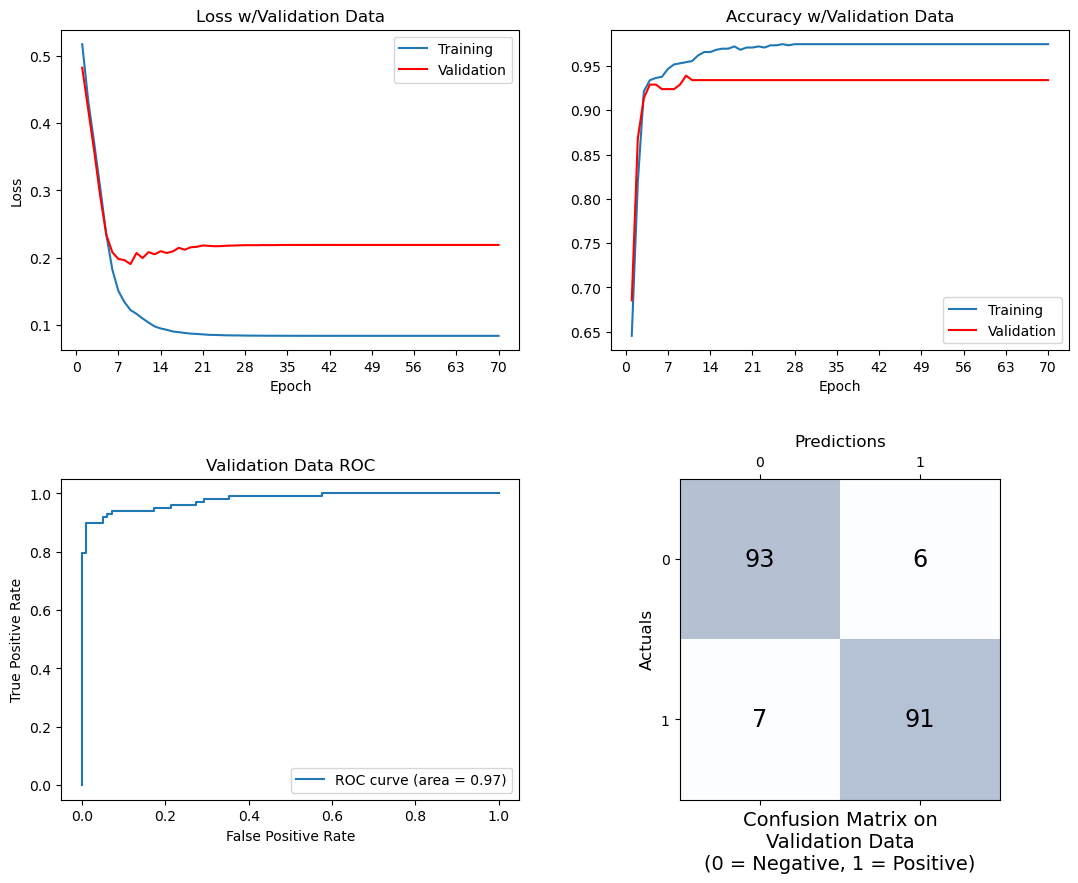

In [80]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = "relu"))
stackedEncoder.add(Dense(8, activation = "relu"))
stackedEncoder.add(Dense(4, activation = "relu"))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(8, activation = "relu"))
stackedDecoder.add(Dense(16, activation = "relu"))
stackedDecoder.add(Dense(numFeatures, activation = "relu"))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model = keras.models.Sequential([stackedEncoder, stackedDecoder])
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False),  
      metrics = METRICS
)

input_shape = (None, numFeatures)
model.build(input_shape)

histModel_4 = model.fit(X_train, y_train, epochs = 100, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_4.history, y_test, model.predict(X_test))

As a final attempt to enhance the model, we decided to remove certain columns based on the visual inspection of the feature density plots. These columns exhibited similar distributions between valid and fraudulent transactions. However, this adjustment resulted in a slight increase in the F1 score at the cost of a lower AUC. Consequently, this modification will also be discarded as it does not provide an overall improvement in performance.

In [81]:
dropColumns = ['V13', 'V15', 'V20', 'V22', 'V23', 'V25', 'V26', 'V28', 'Class']
X_drop = df_balanced.drop(dropColumns, axis = 1).values
numFeatures -= len(dropColumns) - 1
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size = 0.20, random_state = RANDOM_SEED)

7/7 [==============================] - 0s 1ms/step
On the Validation Data
AUC: 0.9684601113172542
F1 Score:  0.9368421052631578


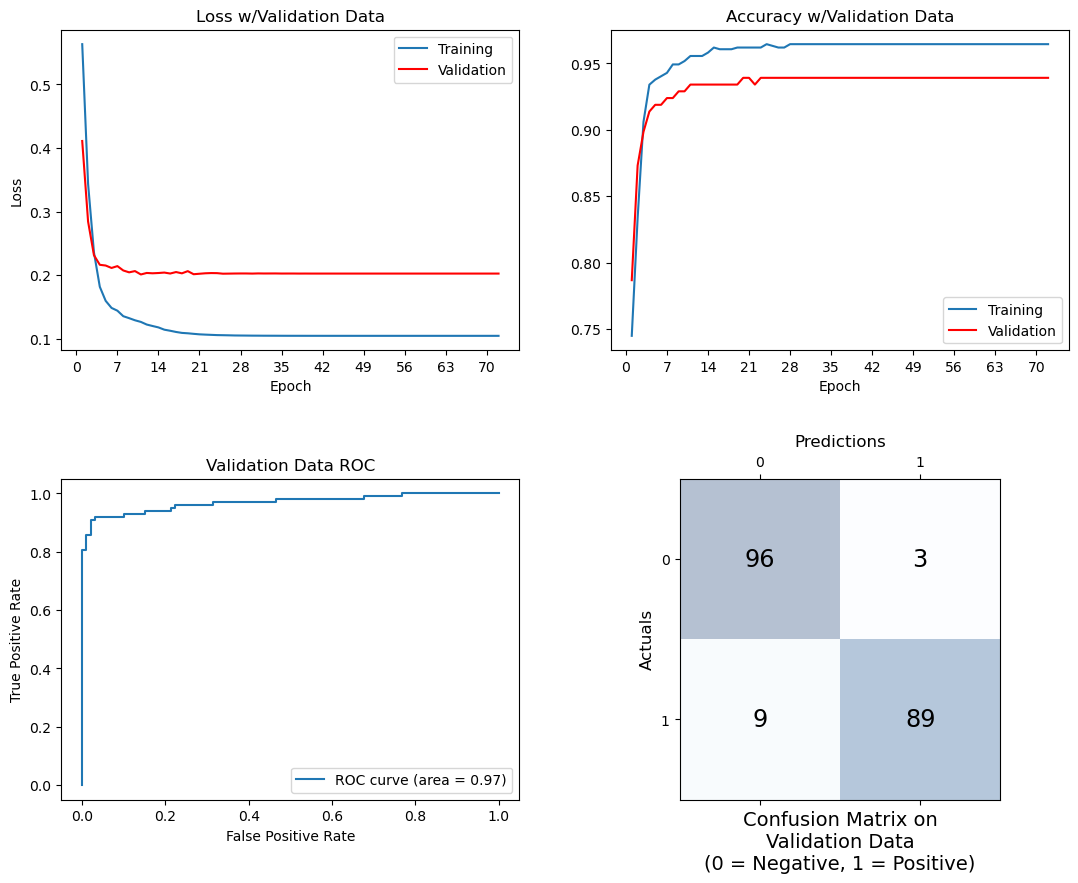

In [83]:
tf.keras.backend.clear_session()

stackedEncoder = keras.models.Sequential()
stackedEncoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedEncoder.add(Dense(4, activation = ENCODER_ACTIVATION))

stackedDecoder = keras.models.Sequential()
stackedDecoder.add(Dense(8, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(16, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(numFeatures, activation = ENCODER_ACTIVATION))
stackedDecoder.add(Dense(1, activation = "sigmoid"))

model = keras.models.Sequential([stackedEncoder, stackedDecoder])
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), 
      loss = keras.losses.BinaryCrossentropy(from_logits = False), 
      metrics = METRICS
)

input_shape = (None, numFeatures)
model.build(input_shape)

histModel_7 = model.fit(X_train, y_train, epochs = 150, validation_data = [X_test, y_test], 
    callbacks = callbacks_list, verbose = False
)

plotResults(0, histModel_7.history, y_test, model.predict(X_test))

#### Test:

In [146]:
loadedModel = tf.keras.models.load_model(os.path.join("./Models/", "final_model.h5"))
loadedModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 4)                 652       
                                                                 
 sequential_1 (Sequential)   (None, 1)                 707       
                                                                 
Total params: 1,359
Trainable params: 1,359
Non-trainable params: 0
_________________________________________________________________


Due to the unbalanced nature of the dataset, the accuracy of the confusion matrix is not a meaningful metric. Therefore, only the receiver operating characteristic (ROC) curve is displayed below to evaluate the model's performance.

Even when applied to the full dataset, the model continues to demonstrate excellent performance, achieving an AUC of approximately 0.9871. This indicates that the model maintains its high level of accuracy in distinguishing between valid and fraudulent transactions even with a larger dataset.

8901/8901 [==============================] - 9s 976us/step
AUC: 0.9871420382951522


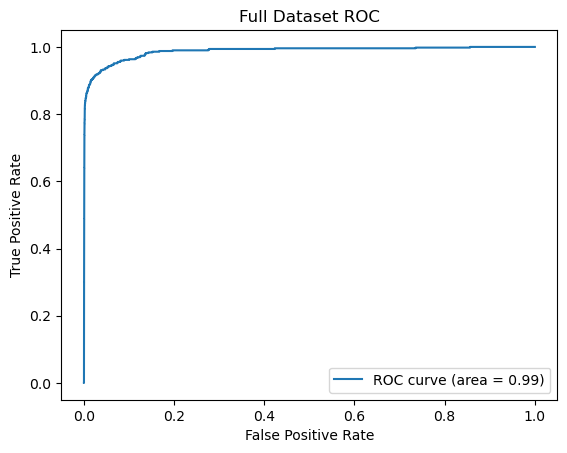

In [148]:
y_full = df_cc_all.Class.values
X_full = df_cc_all.drop('Class', axis = 1).values

preds = loadedModel.predict(X_full)

fullDatasetAUC = roc_auc_score(y_full, preds)
print("AUC:", fullDatasetAUC)

fpr, tpr, threshold = roc_curve(y_full, preds)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % fullDatasetAUC)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Full Dataset ROC")
plt.legend(loc="lower right")

plt.show()

#### Results and Analysis:
Among all the models and architectures tested, the best outcome was attained with a 3-layer autoencoder architecture. The original 29 features were downsampled from 29 to 16, then to 8, and finally to 4. Subsequently, the features were upsampled from 4 to 8, then to 16, and finally to 29. This configuration yielded outstanding performance on the full dataset, achieving an AUC score of approximately 0.9871 and a recall of approximately 0.9411.

Below are the results of all the models and architectures tested on the balanced dataset:

Basic Autoencoder: AUC ≈ 0.9816, F1 ≈ 0.9271
Autoencoder with Additional Dense Layers: AUC ≈ 0.9837, F1 ≈ 0.9223
3-Layer Autoencoder (Best Result): AUC ≈ 0.9863, F1 ≈ 0.9326
These results highlight the superior performance of the 3-layer autoencoder architecture compared to the other models when dealing with the balanced dataset.

| Model Description | AUC Score | F1 Score |
|---|---|---|
| One Layer | 0.9816 | 0.9271 |
| Two Layer | 0.9837 | 0.9223 |
| Three Layer | 0.9863 | 0.9326 |
| Three Layer w/MSE | 0.9810 | 0.9333 |
| Three Layer w/ReLU | 0.9774 | 0.9333 |
| Three Layer & Drop Cols | 0.9685 | 0.9368 |

It is important to note that the results obtained from the different model architectures tested exhibit a high degree of similarity. In fact, when re-fitting a single model architecture against the balanced dataset, the scores may vary by approximately ±2% at times. This variability signifies that attempting to replicate these specific results may yield slightly different outcomes for other individuals. However, any differences observed are expected to be minor.

#### Conclusion:
The performance of even a simple one-layer encoder in predicting fraudulent credit card transactions was surprisingly good. Although the final model utilized a three-layer architecture, the increase in both AUC and F1 score was only approximately 0.005. The initial results achieved by adding a couple of layers were already so promising that further tuning attempts were deemed unnecessary.

One area for improvement in the creation and evaluation of these models would be to consider the Precision-Recall score in addition to AUC and F1 score. The Precision-Recall score is a more suitable metric for evaluating models in cases where there is a significant imbalance in the dataset. Reassessing each of the model architectures and tuning variations using this metric could potentially lead to the selection of a different model as the top performer.